In [1]:
from astropy.io import fits
import sys
import pandas as pd
from astropy.table import unique, Table
import astropy
from matplotlib import pyplot as plt
import numpy as np
from numcosmo_py import Ncm, Nc, sky_match
from numcosmo_py.external.pyssc import pyssc as PySSC
import timeit
Ncm.cfg_init()

from getdist.mcsamples import  MCSamples
from getdist import plots

import getdist
sys.path.insert(0, "/global/homes/l/lettieri/gcrcatalogs-new/gcr-catalogs")
sys.path.insert(0, "/global/homes/l/lettieri/gcr-catalogs")
import GCRCatalogs
GCRCatalogs.set_root_dir_by_site("nersc")
from GCR import GCRQuery

%matplotlib inline

In [2]:
zmin = 0.0
zmax = 1.2
logMmin = 13.0
logMmax = 16.0

image_cat = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image')

# Taking some important information about the fiducial cosmological model and survey region
dc2_cosmology = image_cat.cosmology
sky_area = image_cat.sky_area

data_dc2 = image_cat.get_quantities(
    ["halo_id" , "redshift_true", "halo_mass", "ra_true", "dec_true"],
    filters=[
        f"redshift_true > {zmin}",
        f"redshift_true < {zmax}",
        f"halo_mass > {10**logMmin}",
        f"halo_mass < {10**logMmax}",
        f"is_central == {True}", 
    ],
)

data_dc2 = Table(data_dc2)
print(data_dc2.columns)
data_dc2['halo_mass'] = np.log10(data_dc2['halo_mass'])

print(len(data_dc2))


print("ra interval")
print(data_dc2['ra_true'].min())
print(data_dc2['ra_true'].max())
print('\n')

print("dec interval")
print(data_dc2['dec_true'].min())
print(data_dc2['dec_true'].max())
print('\n')

print("z interval")
print(data_dc2['redshift_true'].min())
print(data_dc2['redshift_true'].max())
print('\n')

print("Mass interval")
print(data_dc2['halo_mass'].min())
print(data_dc2['halo_mass'].max())
print('\n')

print("sky_area = %.3f sqd" % (sky_area))

zmin = data_dc2['redshift_true'].min()
zmax = data_dc2['redshift_true'].max()
lnMmin = np.log(10) * data_dc2['halo_mass'].min()
lnMmax = np.log(10) * data_dc2['halo_mass'].max()


<TableColumns names=('halo_mass','redshift_true','ra_true','dec_true','halo_id')>
249573
ra interval
47.82629157861663
75.90450973340013


dec interval
-46.56263345432947
-24.641586877718865


z interval
0.01577138900756836
1.1999938488006592


Mass interval
13.00011064929296
15.278039264606997


sky_area = 439.790 sqd


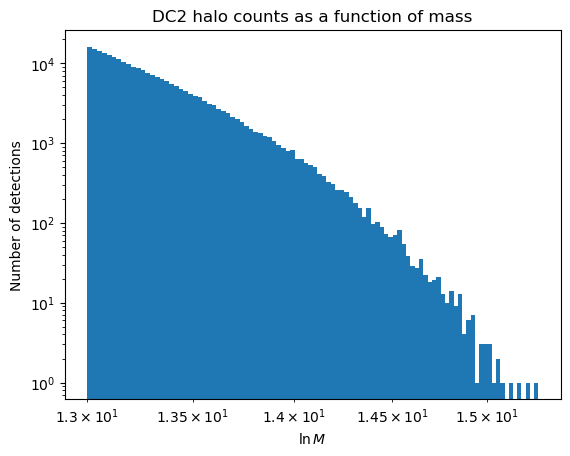

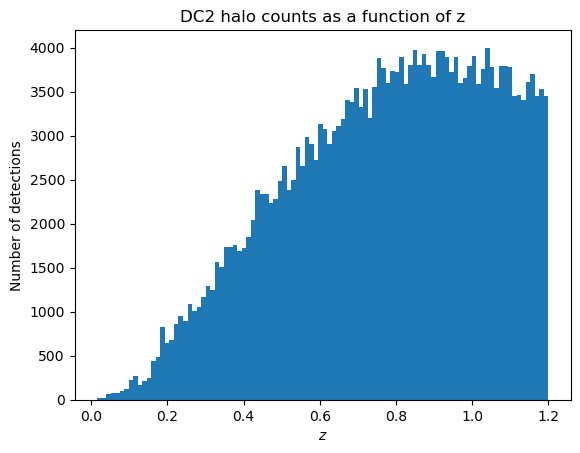

In [3]:
plt.hist(data_dc2['halo_mass'],bins=100)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Number of detections")
plt.xlabel(r"$\ln M$")
plt.title("DC2 halo counts as a function of mass")
plt.show()

plt.hist(data_dc2['redshift_true'],bins=100)
plt.title("DC2 halo counts as a function of z")
plt.ylabel("Number of detections")
plt.xlabel(r"$z$")
plt.show()

# Cosmological Model

In [4]:
#cosmological model
cosmo = Nc.HICosmoDEXcdm()
cosmo.omega_x2omega_k()
cosmo.param_set_by_name("Omegak", 0.00)
#cosmo.param_set_by_name("Omegax", dc2_cosmology.Ode0)
cosmo.param_set_by_name("H0", dc2_cosmology.H0.value)
cosmo.param_set_by_name("Omegab", dc2_cosmology.Ob0)
cosmo.param_set_by_name("Omegac", dc2_cosmology.Odm0)  # 0.2603

cosmo.param_set_by_name("w", -1.0)  # -1.0

prim = Nc.HIPrimPowerLaw.new()
prim.param_set_by_name("ln10e10ASA", 3.0)
prim.props.n_SA = dc2_cosmology.n_s
reion = Nc.HIReionCamb.new()

cosmo.add_submodel(prim)
cosmo.add_submodel(reion)

#matter power spectrum
tf = Nc.TransferFuncEH()

psml = Nc.PowspecMLTransfer.new(tf)
psml.require_kmin(1.0e-6)
psml.require_kmax(1.0e3)

psf = Ncm.PowspecFilter.new(psml, Ncm.PowspecFilterType.TOPHAT)
psf.set_best_lnr0()
psf.prepare(cosmo)
print(cosmo.sigma8(psf))

old_amplitude = np.exp(prim.props.ln10e10ASA)
prim.props.ln10e10ASA = np.log(
    (dc2_cosmology.sigma8 / cosmo.sigma8(psf)) ** 2 * old_amplitude
)
print(dc2_cosmology.sigma8, cosmo.sigma8(psf) , prim.props.ln10e10ASA)



dist = Nc.Distance.new(2.0)
dist.prepare(cosmo)

#parameters to be fitted

cosmo.set_property("Omegac_fit", True)
cosmo.set_property("w_fit", True)
prim.set_property("ln10e10ASA_fit", True)

0.7763884572510941
0.8 0.7999999999999999 3.059917486993207


# Cluster Mass-Richness and photoz model 

In [5]:
#mass proxy
cluster_m = Nc.ClusterMassNodist(lnM_min=14 *np.log(10), lnM_max=16 *np.log(10))

#photo-z
cluster_z = Nc.ClusterRedshiftNodist (z_min = zmin, z_max = zmax)

# Cluster abundance model

## HMF as a function of mass

5352.518051566433


/tmp/ipykernel_853632/132861859.py:35: RuntimeWarning: divide by zero encountered in scalar divide
  diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]


5460.218936688445
6909.757697730974


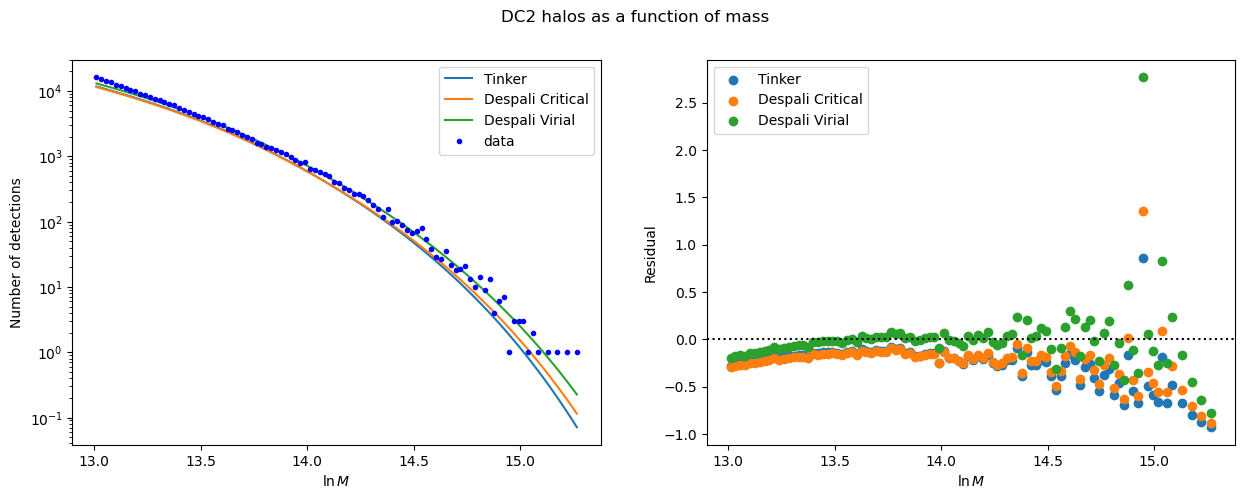

In [6]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100

lnM = np.linspace(lnMmin, lnMmax , nbins +1)
lnM_bin = [(lnM[j] +lnM[j+1])/2 for j in range(len(lnM)-1)]
counts_lnM, bins = np.histogram(data_dc2['halo_mass'] * np.log(10), bins=lnM)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle("DC2 halos as a function of mass")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL) 

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    #hbias = Nc.HaloBiasTinker.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, None)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnM[j]] , [lnM[j+1]], None, [zmin] , [zmax] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_lnM[j])/counts_lnM[j] for j in range(len(lnM)-1)]

    #PLOT
    
    
    ax1.plot(lnM_bin/np.log(10),abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(lnM_bin/np.log(10),diff, label=mulf_label[i])


ax1.plot(lnM_bin/np.log(10),counts_lnM,'.b',label='data') #Noisy data
ax1.set_ylabel("Number of detections")
ax1.set_xlabel(r"$\ln M$")
ax2.axhline(y=0.0, color='black', linestyle='dotted')
ax1.legend()
ax2.set_xlabel(r"$\ln M$")
ax2.set_ylabel("Residual")
ax2.legend()
plt.show()

## HMF as a function of z

5352.518051566433
5460.218936688445
6909.757697730974


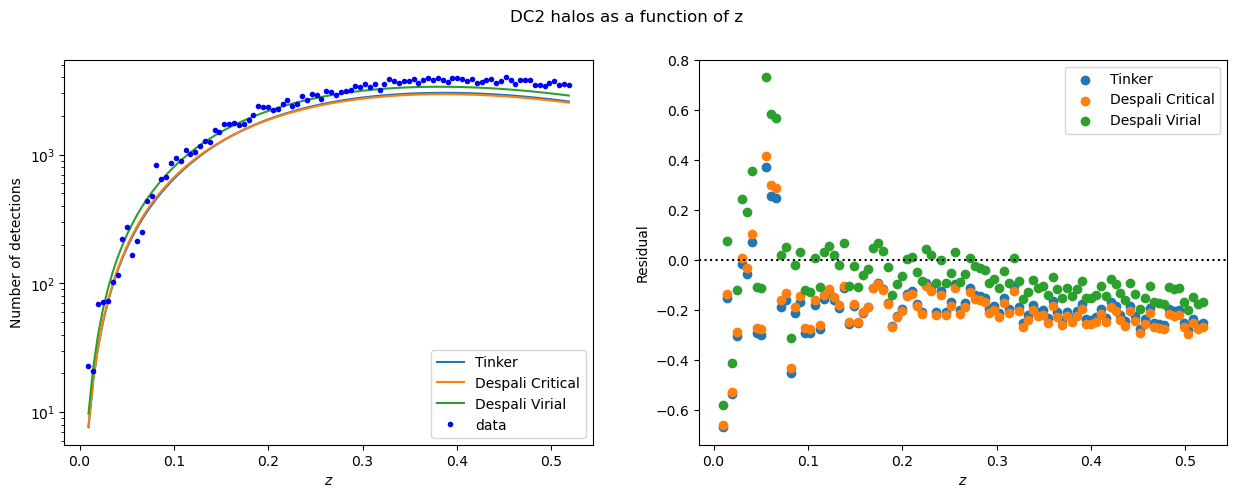

In [7]:
mulfs = [Nc.MultiplicityFuncTinker.new() , Nc.MultiplicityFuncDespali.new(), Nc.MultiplicityFuncDespali.new()]
mulf_label = ["Tinker", "Despali Critical" , "Despali Virial"]
nbins=100
z = np.linspace(zmin, zmax , nbins +1)
z_bin = [(z[j] +z[j+1])/2 for j in range(len(z)-1)]
counts_z, bins = np.histogram(data_dc2['redshift_true'], bins=z)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(15)
fig.suptitle("DC2 halos as a function of z")
for i in range(len(mulfs)):
    diff = []
    mulf = mulfs[i]
    if i == 2:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.VIRIAL) 

    else:
        mulf.set_mdef(Nc.MultiplicityFuncMassDef.CRITICAL)
        mulf.set_Delta(200.0)
    
    hmf = Nc.HaloMassFunction.new(dist, psf, mulf)
    hmf.prepare(cosmo)
    hmf.set_area(sky_area * (np.pi / 180) ** 2)
    #hbias = Nc.HaloBiasTinker.new(hmf)
    cad = Nc.ClusterAbundance.new(hmf, None)
    cad.set_area(sky_area * (np.pi / 180) ** 2)
    
    
    cad.prepare(cosmo , cluster_z , cluster_m)
    print(cad.n(cosmo ,cluster_z , cluster_m))
    
    abundance = [cad.intp_bin_d2n(cosmo, cluster_z, cluster_m, [lnMmin] , [lnMmax], None, [z[j]] , [z[j+1]] , None)  for j in range(len(lnM)-1)]
    diff = [(abundance[j] - counts_z[j])/counts_z[j] for j in range(len(z)-1)]

    #PLOT
    
    
    ax1.plot(z_bin/np.log(10),abundance,'-', label=mulf_label[i]) #Best fit model
    #plt.axis([lnM_bin[0], lnM_bin[-1], 0.0,counts_lnM.max()])
    
    ax1.set_yscale("log")
    #plt.axis([lnM_bin[0], lnM_bin[-1], counts_lnM.min(),counts_lnM.max()])
    ax2.scatter(z_bin/np.log(10),diff, label=mulf_label[i])


ax1.plot(z_bin/np.log(10),counts_z,'.b',label='data') #Noisy data
ax1.set_ylabel("Number of detections")
ax1.set_xlabel(r"$z$")
ax2.axhline(y=0.0, color='black', linestyle='dotted')
ax1.legend()
ax2.set_xlabel(r"$z$")
ax2.set_ylabel("Residual")
ax2.legend()
plt.show()